In [1]:
import json
import munch

import tensorflow as tf
import numpy as np
import sde as eqn
import options as opts
import solvers as sls
from trainer import BSDETrainer
from options import LookbackOption, GeometricAsian
from function_space import DeepONet, DeepONetwithPI

import matplotlib.pyplot as plt
from utils import mc_price
import os
print(os.getcwd())
sde_list = ["GBM", "TGBM", "SV", "CEV", "SVJ"]
option_list = ["European", "EuropeanPut", "Lookback", "Asian", "Basket", "BasketnoPI", "Swap", "TimeEuropean", "TimeEuropeanBasketOption", "BermudanPut"]
dim_list = [1, 3, 5, 10, 20]

/home/wyzhang/chenjie/no_bsde


In [5]:
np.sqrt(0.00158)

0.03974921382870358

In [14]:
def get_useful_series(sde_name: str, option_name: str, dim: int=1, seed: int=0, training=True):
    tf.random.set_seed(seed)
    np.random.seed(seed)
   
    if (sde_name not in sde_list) or (option_name not in option_list) or (dim not in dim_list):
        raise ValueError(f"please input right sde_name in {sde_list},\
                          option_name in {option_list} and dim in {dim_list}")
    else:
        json_path = f'config/{sde_name}_{option_name}_{dim}.json'
    with open(json_path) as json_data_file:
        config = json.load(json_data_file)
    
    config = munch.munchify(config)
    sde = getattr(eqn, config.eqn_config.sde_name)(config)
    option = getattr(opts, config.eqn_config.option_name)(config)
    print(option)
    solver = getattr(sls, config.eqn_config.solver_name)(sde, option, config)
    trainer = BSDETrainer(solver)
    model = trainer.solver
    mode = config.eqn_config.initial_mode
    
    
    u_model = sde.sample_parameters(N=2, training=training)
    u_option = option.sample_parameters(N=2, training=training)
    u_hat = tf.concat([u_model, u_option], axis=-1)
    x, _ = sde.sde_simulation(u_hat, config.val_config.sample_size)
    time_stamp = tf.range(0, config.eqn_config.T, config.eqn_config.dt)
    time_steps = config.eqn_config.time_steps
    time_stamp = tf.reshape(time_stamp, [1, 1, time_steps, 1])
    t = tf.tile(time_stamp, [u_hat.shape[0], config.eqn_config.sample_size, 1, 1])
    u_hat = sde.expand_batch_inputs_dim(u_hat)
    # model.load_weights(f"checkpoint/{sde_name}_{option_name}_{dim}")
    print(config.net_config.kernel_type)


    model.no_net.load_weights(f"checkpoint/{sde_name}_{option_name}_{dim}_{mode}_{config.net_config.kernel_type}")
    if type(option) == LookbackOption or type(option) == GeometricAsian:
        x_m = option.markovian_var(x)
        x_arg = tf.concat([x, x_m], axis=-1)
    else: 
        x_arg = x
    print(f"asset's shepe: {x_arg.shape}")
    y_pred = model.net_forward((t, x_arg, u_hat))
    z_pred = tf.squeeze(model.z_hedge(t, x_arg, u_hat)).numpy()
    y_pred = tf.squeeze(y_pred).numpy()
    t_test = tf.squeeze(t).numpy()
    x_mc = tf.squeeze(np.mean(x_arg[:,:,:,:dim], axis=-1)).numpy()
    # x_mc = np.mean(x_mc, axis=-1)
    u = tf.squeeze(u_hat[:, 0,0, :]).numpy()
    print(f"parameters shape: {u.shape}")

    mc_p = mc_price(x_arg[:,:,:,:dim], u_hat[:, 0,0, :])

    if (sde_name in ["GBM", "TGBM", "SV"]) and (option_name in ["European", "EuropeanPut","Swap", "TimeEuropean", "BermudanPut"]) and (dim in[1, 3, 5, 10]):
        y_true = option.exact_price(t, x, u_hat)
        z_true = tf.squeeze(option.exact_delta(t, x, u_hat)).numpy()
        y_true = tf.squeeze(y_true).numpy()
    
        return y_pred, x_mc, t_test, u, y_true, z_pred, z_true
    
    if (sde_name in [ "SV"]) and (option_name in [ "Swap"]) and (dim != 1):
        y_true = option.exact_price(t, x, u_hat)
        # z_true = tf.squeeze(option.exact_delta(t, x, u_hat)).numpy()
        y_true = tf.squeeze(y_true).numpy()
    
        return y_pred, x_mc, t_test, u, y_true, _, _
    
    elif (sde_name == "GBM") and (option_name in ["Lookback", "Asian"]) and (dim in [1, 3, 10]):
        y_true = option.exact_price(t, x_arg, u_hat)
        # z_true = tf.squeeze(option.exact_delta(t, x_arg, u_hat)).numpy()
        y_true = tf.squeeze(y_true).numpy()
        return y_pred, x_mc, t_test, u, y_true, _, _

    
    elif sde_name == "GBM" and option_name == "BasketnoPI" and dim != 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        x_mc = tf.reduce_mean(x_arg, axis=-1)
        x_mc = tf.squeeze(x_mc).numpy()
        return y_pred, x_mc, t_test, u, y_true, _, _
    
    elif sde_name == "GBM" and option_name == "Basket" and dim != 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        x_mc = tf.reduce_mean(x_arg, axis=-1)
        x_mc = tf.squeeze(x_mc).numpy()
        return y_pred, x_mc, t_test, u, y_true, _, _
    
    else:
        return y_pred, x_mc, t_test, u, mc_p.numpy()


# sde_l = ["GBM"]
# opt_l = ["Basket", "BasketnoPI"]
# datas = []
# for sde in sde_l:
#     for option in opt_l:
#         data = get_useful_series(sde, option, 10, 0, False) 
#         datas.append(data)
# data = get_useful_series("GBM", "Basket", 10, 0, True) 
# data1 = get_useful_series("GBM", "BasketnoPI", 10, 0, True)     
# print(data[1][0, :, 0]) 
data = get_useful_series("GBM", "European", 1, 0, False) 
print(data[0].shape, data[4].shape)

EuropeanOption()
dense
asset's shepe: (200, 50, 100, 1)
parameters shape: (200, 3)
(200, 50, 100, 1)
(200, 50, 100) (200, 50, 100)


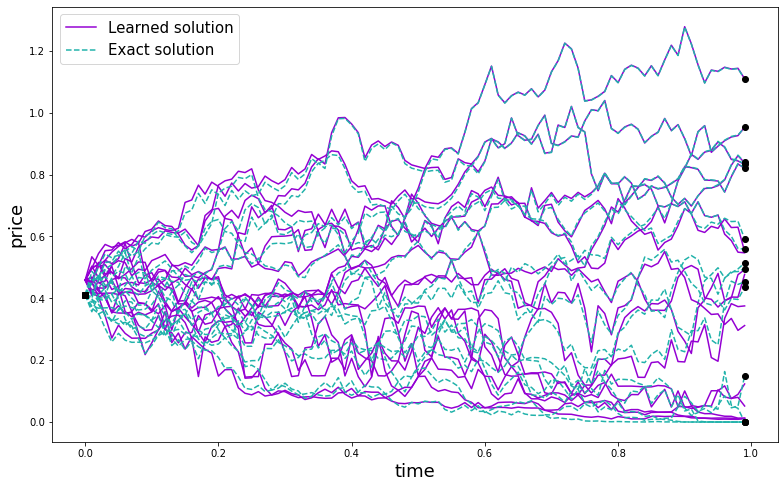

1.1698977 [0.0358395  0.43324843 0.90979356] 0.45866385


In [23]:
def plot_mc_curves(t_test, y_pred, x_mc, u_hat, y_true=None):
    samples = 16
    plt.figure(figsize=(13, 8))
    plt.plot(t_test[0:1,:].T, y_pred[0:1,:].T,'darkviolet',label='Learned solution')
    plt.plot(t_test[0:1,:].T, y_true[0:1,:].T,'--',color='lightseagreen',label='Exact solution')
    plt.plot(t_test[0:1,-1], y_true[0:1,-1],'ko') #,label='$Y_T = u(T,X_T)$')

    plt.plot(t_test[1:samples,:].T, y_pred[1:samples,:].T,'darkviolet')
    plt.plot(t_test[1:samples,:].T, y_true[1:samples,:].T,'--',color='lightseagreen')
    plt.plot(t_test[1:samples,-1], y_true[1:samples,-1],'ko')

    plt.plot([0],y_true[0,0],'ks') # ,label='$Y_0 = u(0,X_0)$')

    plt.xlabel('time', fontdict={"size": 18})
    plt.ylabel('price', fontdict={"size": 18})
    #plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, $\theta$={u_hat[1]: 2f},$\kappa$={u_hat[2]: 2f}， $\sigma$={u_hat[3]: 2f}, $\rho$={u_hat[4]: 2f}')# , $\rho$={u_hat[2]: 2f}')
    plt.legend(prop={"size": 15})
    plt.show()
    print(x_mc[0,0], u_hat, y_pred[0,0])
    # plt.figure(figsize=(10, 6))
    # plt.plot(t_test[0:1,:].T, x_mc[0:1,:].T,'g',label='$X_t$')
    # plt.plot(t_test[1:samples,:].T, x_mc[1:samples,:].T,'g')
    # plt.show()
    # print("parameters:", u_hat)
    # t = (y_pred[:,0] - y_true[:,0])/(1 + y_true[:,0])
    # print(np.mean(np.abs(t)), np.std(np.abs(t)))

t_test = np.load('predicted_price/t.npy')
idx_1 = 0
idx = 0 #27 european basket 10，
# for data in datas: 
plot_mc_curves(t_test[idx], data[5][idx], data[1][idx], data[3][idx], data[6][idx])
# plot_mc_curves(t_test[idx], data1[0][idx], data1[1][idx], data1[3][idx], data1[4][idx])
# plot_mc_curves(t_test[idx], data[-2][idx], data[1][idx], data[3][idx], data[-1][idx])

In [2]:
import QuantLib as ql 
maturity_date = ql.Date(8, 5, 2023)
x0 = 0.85712296
r = 0.05
sigma = 0.4
rho = 0.2
k = 1.8
strike_price = k
volatility = sigma # the historical vols or implied vols
dividend_rate =  0.0
option_type = ql.Option.Put

underlying_spots = [x0]*3
underlying_vols = [volatility]*3
underlying_corr_mat = [[1, rho, rho], [rho, 1, rho], [rho, rho, 1]]


risk_free_rate = r
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

calculation_date = ql.Date(8, 5, 2022)
ql.Settings.instance().evaluationDate = calculation_date

payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date

am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

# spot_handle = ql.QuoteHandle(
#     ql.SimpleQuote(spot_price)
# )
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

processes = [ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(x)),
                                          dividend_yield,
                                          flat_ts,
                                          ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, y, day_count)))
             for x, y in zip(underlying_spots, underlying_vols)]

multiProcess = ql.StochasticProcessArray(processes, underlying_corr_mat)
# flat_vol_ts = ql.BlackVolTermStructureHandle(
#     ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
# )
# bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
#                                            dividend_yield, 
#                                            flat_ts, 
#                                            flat_vol_ts)
bermudanExercise = ql.BermudanExercise([ql.Date(8, 5, 2023)])  # ql.Date(3,10,2022), ql.Date(15,12,2022)
bermudanbasketOption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3), bermudanExercise)
bermudanbasketOption.setPricingEngine(
    ql.MCAmericanBasketEngine(
        multiProcess,
        "pseudorandom",
        timeSteps=10,
        requiredTolerance=0.02,
        seed=42,
        polynomOrder=5,
        polynomType=ql.LsmBasisSystem.Hermite,
    )
)
# bermudanOption.setPricingEngine(engine)
print ("Basket Bermudan Exercise: ", bermudanbasketOption.NPV())


# americanExercise = ql.AmericanExercise(calculation_date, maturity_date)
# americanbasketoption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3),  americanExercise)
# americanbasketoption.setPricingEngine(
#     ql.MCAmericanBasketEngine(
#         multiProcess,
#         "pseudorandom",
#         timeSteps=10,
#         requiredTolerance=0.02,
#         seed=42,
#         polynomOrder=5,
#         polynomType=ql.LsmBasisSystem.Hermite,
#     )
# )
# print("Basket American Exercise: ", americanbasketoption.NPV())



basketoption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3), ql.EuropeanExercise(ql.Date(8, 5, 2023)))
basketoption.setPricingEngine(
    ql.MCEuropeanBasketEngine(multiProcess, "pseudorandom", timeStepsPerYear=1, requiredTolerance=0.02, seed=42)
)
print("Average Basket Payoff: ", basketoption.NPV())

Basket Bermudan Exercise:  0.9259224810943525
Average Basket Payoff:  0.852197609371208


In [17]:
def evaluate(data):
    y_pred, x_mc, t_test, u, mc_p, z_pred, z_true= data
    if mc_p.ndim == 1:
        t = np.abs(y_pred[:,0,0] - mc_p)
    else:
        idx=-1
        t = (np.abs(y_pred[:,:,:idx] - mc_p[:,:,:idx]))/(1 + mc_p[:,:,:idx])
        t_z = (np.abs(z_pred[:,:,idx] - z_true[:,:,idx]))/(1 + z_true[:,:,idx])
    return [np.mean(t), np.std(t)], [np.mean(t_z), np.std(t_z)]

# print(data[1].shape, data[4].shape)

print(evaluate(data)) 


([0.009265071, 0.007498787], [0.028620606, 0.030069098])


(400, 20, 100) (400, 20, 99, 10)
(400, 4)
([0.030073075, 0.025054304], [0.0, 0.0])


<Figure size 144x432 with 0 Axes>

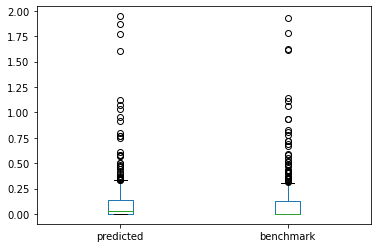

(400, 4)
([0.03450442, 0.026437214], [0.0, 0.0])


<Figure size 144x432 with 0 Axes>

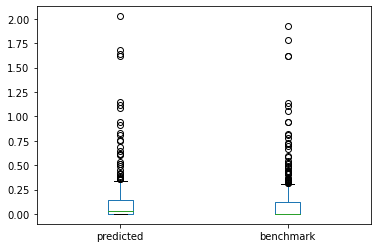

In [8]:
import pandas as pd
def evaluate0(data):
    y_pred, x_mc, t_test, u, mc_p, z_pred, z_true= data
    if mc_p.ndim == 1:
        t = np.abs(y_pred[:,0,0] - mc_p)
    else:
        idx=1
        t = np.abs(y_pred[:,:,0] - mc_p[:,:,0])
        t_z = np.abs(z_pred[:,:,:] - z_true[:,:,:])
    return [np.mean(t), np.std(t)], [np.mean(t_z), np.std(t_z)]

print(data[1].shape, data[-1].shape)
for data in datas:
    print(data[3].shape)
    print(evaluate0(data)) 
    idx=-1
    plt.figure(figsize=(2, 6))
    y_1 = data[0][:,0,idx]
    y_2 = data[4][:,0,idx]
    y = {"predicted": y_1, "benchmark": y_2}
    df = pd.DataFrame(y)
    df.plot.box()
    plt.show()


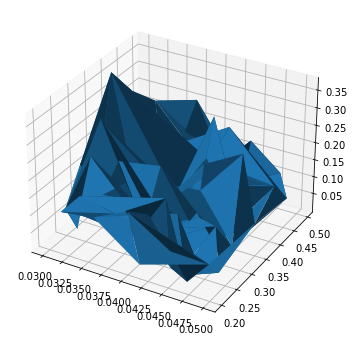

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# data = # your matrix here

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
for data in datas:
    r = data[3][:, 0]
    s = data[3][:, 1]
    p = data[0][:,0,0]
    p1 = data[4][:,0,0]

ax.plot_trisurf(r,s,np.abs(p))

In [1]:

import tf_quant_finance as tff 

/home/wyzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
import QuantLib as ql 
maturity_date = ql.Date(8, 5, 2023) #到期日
x0 = 0.8194046
r = 0.0453933
sigma = 0.69314367 
rho = 0.6762595  
k = 1.9476937 
strike_price = k
volatility = sigma # the historical vols or implied vols
dividend_rate =  0.0
option_type = ql.Option.Put

underlying_spots = [x0]*3
underlying_vols = [volatility]*3
underlying_corr_mat = [[1, rho, rho], [rho, 1, rho], [rho, rho, 1]]


risk_free_rate = 0.05
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

calculation_date = ql.Date(8, 5, 2022) #计价日
ql.Settings.instance().evaluationDate = calculation_date

payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date

# am_exercise = ql.AmericanExercise(settlement, maturity_date)
# american_option = ql.VanillaOption(payoff, am_exercise)

# spot_handle = ql.QuoteHandle(
#     ql.SimpleQuote(spot_price)
# )
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

processes = [ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(x)),
                                          dividend_yield,
                                          flat_ts,
                                          ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, y, day_count)))
             for x, y in zip(underlying_spots, underlying_vols)]

multiProcess = ql.StochasticProcessArray(processes, underlying_corr_mat)
# flat_vol_ts = ql.BlackVolTermStructureHandle(
#     ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
# )
# bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
#                                            dividend_yield, 
#                                            flat_ts, 
#                                            flat_vol_ts)
bermudanExercise = ql.BermudanExercise([ql.Date(3,10,2022), ql.Date(15,12,2022)])
bermudanbasketOption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3), bermudanExercise)
bermudanbasketOption.setPricingEngine(
    ql.MCAmericanBasketEngine(
        multiProcess,
        "pseudorandom",
        timeSteps=10,
        requiredTolerance=0.02,
        seed=42,
        polynomOrder=5,
        polynomType=ql.LsmBasisSystem.Hermite,
    )
)
# bermudanOption.setPricingEngine(engine)
print ("Basket Bermudan Exercise: ", bermudanbasketOption.NPV())


americanExercise = ql.AmericanExercise(calculation_date, maturity_date)
americanbasketoption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3),  americanExercise)
americanbasketoption.setPricingEngine(
    ql.MCAmericanBasketEngine(
        multiProcess,
        "pseudorandom",
        timeSteps=10,
        requiredTolerance=0.02,
        seed=42,
        polynomOrder=5,
        polynomType=ql.LsmBasisSystem.Hermite,
    )
)
print("Basket American Exercise: ", americanbasketoption.NPV())



basketoption = ql.BasketOption(ql.AverageBasketPayoff(payoff, 3), ql.EuropeanExercise(ql.Date(8, 5, 2023)))
basketoption.setPricingEngine(
    ql.MCEuropeanBasketEngine(multiProcess, "pseudorandom", timeStepsPerYear=1, requiredTolerance=0.02, seed=42)
)
print("Average Basket Payoff: ", basketoption.NPV())

Basket Bermudan Exercise:  1.1195250616680943
Basket American Exercise:  1.1202616580986728
Average Basket Payoff:  1.062738623676084
